In [2]:
# evaluate the change of the VarBC coefficients
# initial built: 2024/06/19

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
print(cartopy.__version__)

0.21.1


In [3]:
inq_time = '2022061500'
expname  = ['CTRL']
instr    = 'amsua'
chn      = 1

rr={};
for i in range(len(expname)):
    if expname[i] == 'CTRL':
        rr[i]=nc.Dataset(f"/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/scrub/radstats/{instr}/new_ctrl_amsua_atms/diag_amsua_n15_ges.{inq_time}.nc4")
    elif expname[i] == 'old_ctrl':
        rr[i]=nc.Dataset(f"/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/scrub/radstats/{instr}/s2022_C192_v2p5_edmf1ens0/diag_amsua_n15_ges.{inq_time}.nc4")
    elif expname[i] == 'CTRL_no_situ':
        rr[i]=nc.Dataset(f"/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/scrub/radstats/{instr}/new_ctrl_amsua_atms_no_situ_only_scatter_wind/diag_amsua_n15_ges.{inq_time}.nc4")
    elif expname[i] == 'ng_v0':
        rr[i]=nc.Dataset(f"/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/scrub/radstats/{instr}/shield_ensreplay_ng_only_scatter_wind_v0/diag_amsua_n15_ges.{inq_time}.nc4")


In [5]:
lat={}; lon={}; omf={}; omfnbc={}; fwater={}; ch={}; qc={};
bc_cnst={}; bc_scan_angle={}; bc_clw={}; bc_lapse={}; bc_lapse_sq={}; bc_emis={}; bc_angord={}; bc_fixed_scan={};

for i in range(len(expname)):
    lat[i]        = rr[i].variables['Latitude'][:]
    lon[i]        = rr[i].variables['Longitude'][:]
    omf[i]        = rr[i].variables['Obs_Minus_Forecast_adjusted'][:]
    omfnbc[i]     = rr[i].variables['Obs_Minus_Forecast_unadjusted'][:]
    fwater[i]     = rr[i].variables['Water_Fraction'][:]
    ch[i]         = rr[i].variables['Channel_Index'][:]
    qc[i]         = rr[i].variables['QC_Flag'][:]

    # varBC coefficients:
    bc_cnst[i]       = rr[i].variables['BC_Constant'][:]
    bc_scan_angle[i] = rr[i].variables['BC_Scan_Angle'][:]
    bc_clw[i]        = rr[i].variables['BC_Cloud_Liquid_Water'][:]
    bc_lapse[i]      = rr[i].variables['BC_Lapse_Rate'][:]
    bc_lapse_sq[i]   = rr[i].variables['BC_Lapse_Rate_Squared'][:]
    bc_emis[i]       = rr[i].variables['BC_Emissivity'][:]
    bc_angord[i]     = rr[i].variables['BC_angord'][:,:] #???
    bc_fixed_scan[i] = rr[i].variables['BC_Fixed_Scan_Position'][:]
    
    #bc_cos_lat    = rr.variables['BC_Cosine_Latitude_times_Node'][:]
    #bc_sin_lat    = rr.variables['BC_Sine_Latitude'][:]
    # bc_fixed_scan = rr.variables['BC_Fixed_Scan_Position'][:] # external?


In [6]:
sea_screen={};
lat_use={}; lon_use={}; omf_use={}; omfnbc_use={}; 
bc_cnst_use={}; bc_lapse_use={}; bc_lapse_sq_use={}; bc_emis_use={}; bc_angord_use={}; bc_fixed_scan_use={};

for i in range(len(expname)):
    sea_screen[i]  = (fwater[i]>= 0.99)
    use            = np.where( (qc[i] == 0)&(ch[i]==chn)&sea_screen[i] )
    #use         =  np.where( (qc == 0)&(ch==chn) )

    lat_use[i]         = lat[i][use]
    lon_use[i]         = lon[i][use]
    omf_use[i]         = omf[i][use]
    omfnbc_use[i]      = omfnbc[i][use]
    bc_cnst_use[i]     = bc_cnst[i][use]
    bc_lapse_use[i]    = bc_lapse[i][use]
    bc_lapse_sq_use[i] = bc_lapse_sq[i][use]
    #bc_clw_use      = bc_clw[use]
    bc_emis_use[i]     = bc_emis[i][use]
    #bc_scan_use     = bc_scan_angle[use]
    #bc_cos_use      = bc_cos_lat[use]
    #bc_sin_use      = bc_sin_lat[use]
    bc_fixed_scan_use[i] = bc_fixed_scan[i][use]

    tmp = np.zeros_like(lat_use[i])
    bc_angord_use[i] = np.tile(tmp,(4,1))

    for j in range(4):
        bc_angord_use[i][j,:]   = bc_angord[i][use,j]

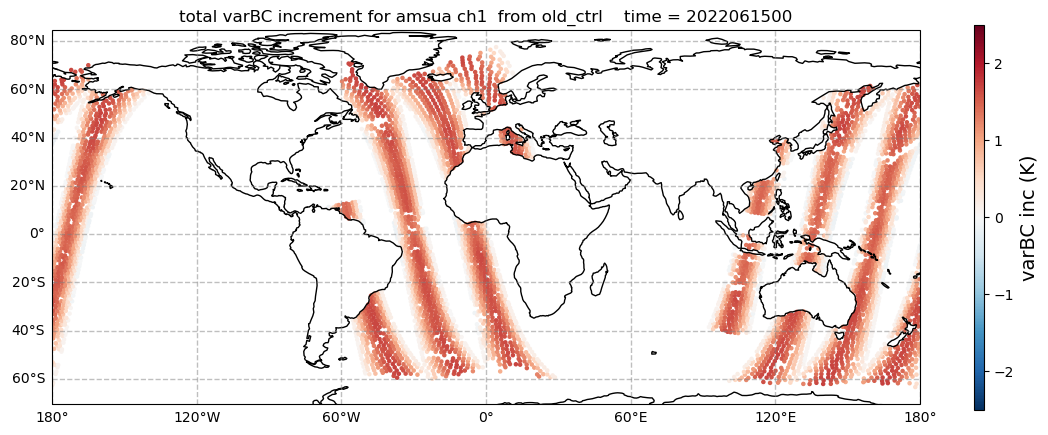

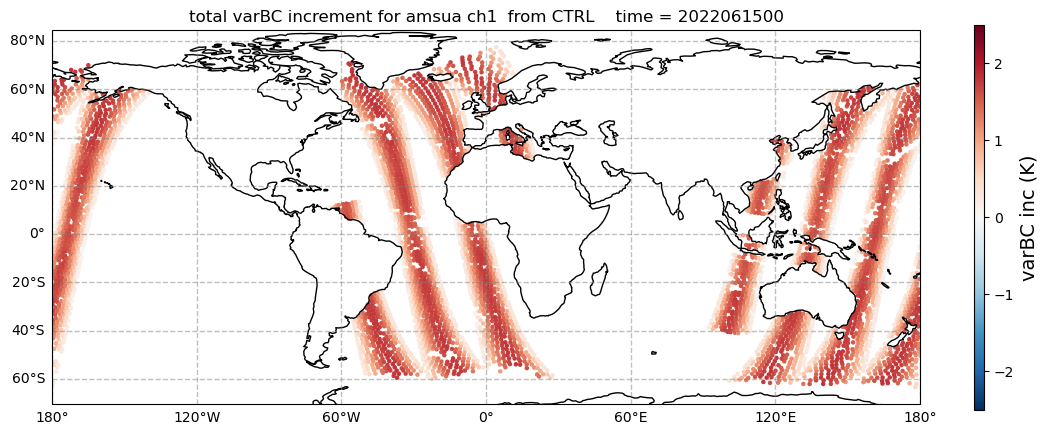

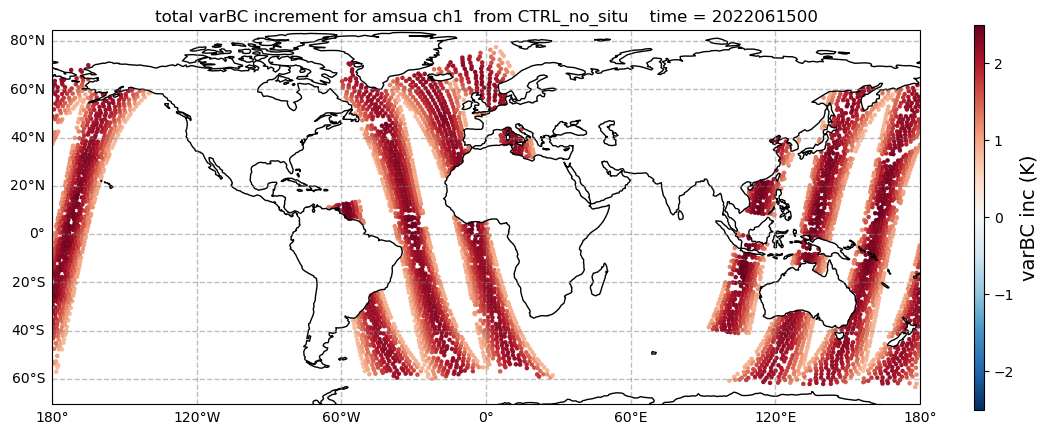

In [484]:
# check the total varBC increment

for i, exp in enumerate(expname):
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot(projection=ccrs.PlateCarree())

    ax.coastlines()
    scatter1 = ax.scatter(lon_use[i], lat_use[i], c=omfnbc_use[i]-omf_use[i], s=5, vmin=-2.5, vmax=2.5, cmap='RdBu_r')
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Hide labels on the top side
    gl.right_labels = False  # Hide labels on the right side
    ax.set_title(f'total varBC increment for {instr} ch{chn}  from {exp}    time = {inq_time}')
    cbar = fig.colorbar(scatter1,location='right',aspect=40)
    cbar.set_label('varBC inc (K)', fontsize=14)

In [15]:
# check the constant and total

for i, exp in enumerate(expname):
    print(f'global mean varBC inc {inq_time} {instr} ch{chn}  from {exp} = ', np.mean(omfnbc_use[i]-omf_use[i]))

print()
    
for i, exp in enumerate(expname):
    print(f'global offset {inq_time} {instr} ch{chn}  from {exp} = ', np.mean(bc_cnst_use[i]))

global mean varBC inc 2022061500 amsua ch1  from old_ctrl =  2.3279486
global mean varBC inc 2022061500 amsua ch1  from CTRL =  2.4886224
global mean varBC inc 2022061500 amsua ch1  from CTRL_no_situ =  3.2292554

global offset 2022061500 amsua ch1  from old_ctrl =  2.7767053
global offset 2022061500 amsua ch1  from CTRL =  2.929623
global offset 2022061500 amsua ch1  from CTRL_no_situ =  3.560772


In [ ]:
1.922737

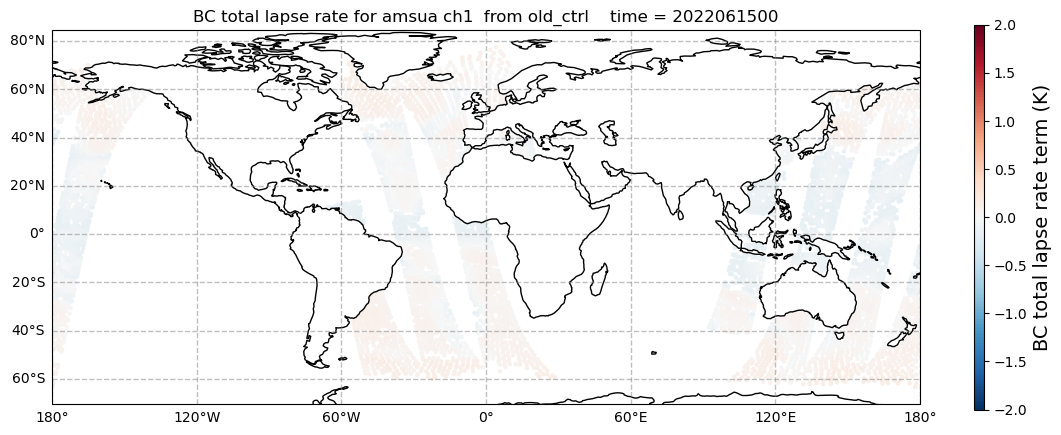

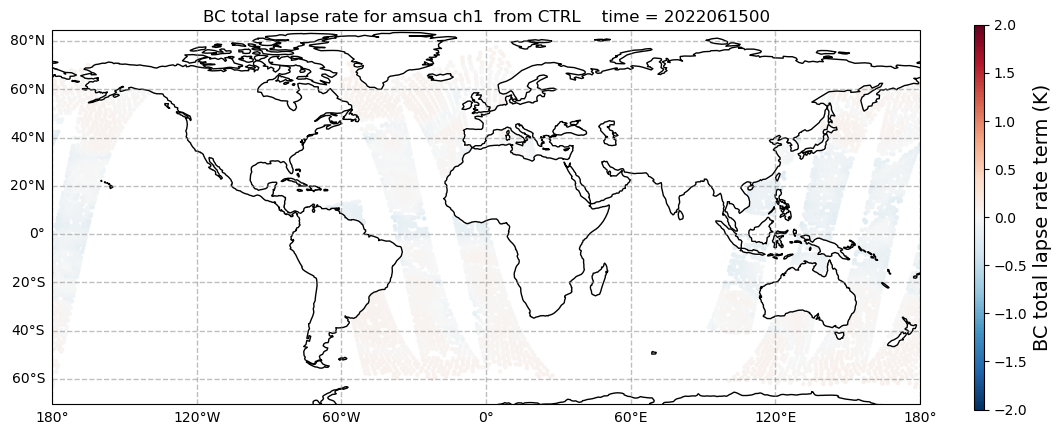

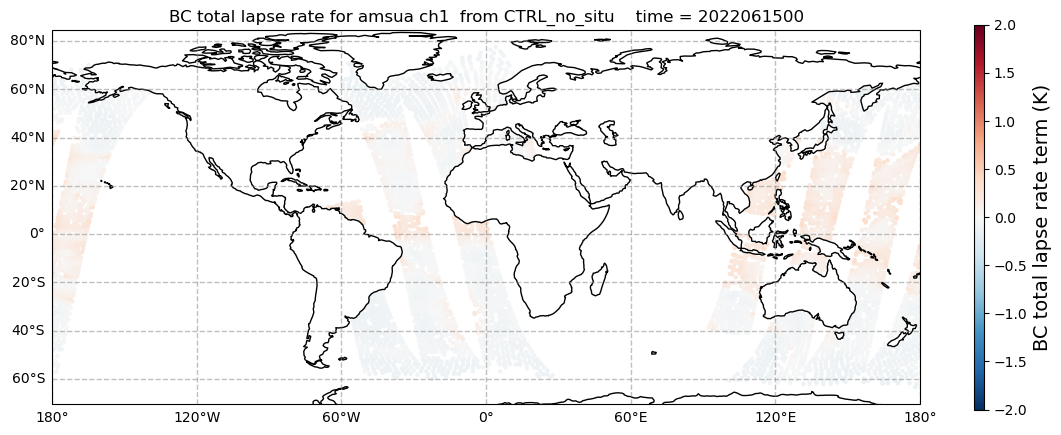

In [491]:
# check the bias correction term (not constant, but predictor*constant) for total lapse rate (linear + squared) 
for i, exp in enumerate(expname):
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot(projection=ccrs.PlateCarree())

    ax.coastlines()
    scatter1 = ax.scatter(lon_use[i], lat_use[i], c=bc_lapse_use[i]+bc_lapse_sq_use[i], s=5, vmin=-2.0, vmax=2.0, cmap='RdBu_r')
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Hide labels on the top side
    gl.right_labels = False  # Hide labels on the right side
    ax.set_title(f'BC total lapse rate for {instr} ch{chn}  from {exp}    time = {inq_time}')
    cbar = fig.colorbar(scatter1,location='right',aspect=40)
    cbar.set_label('BC total lapse rate term (K)', fontsize=14)

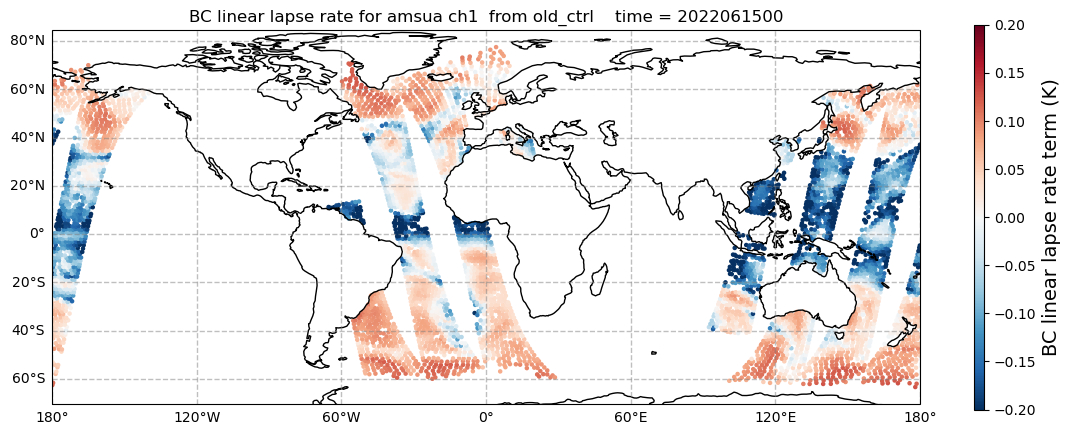

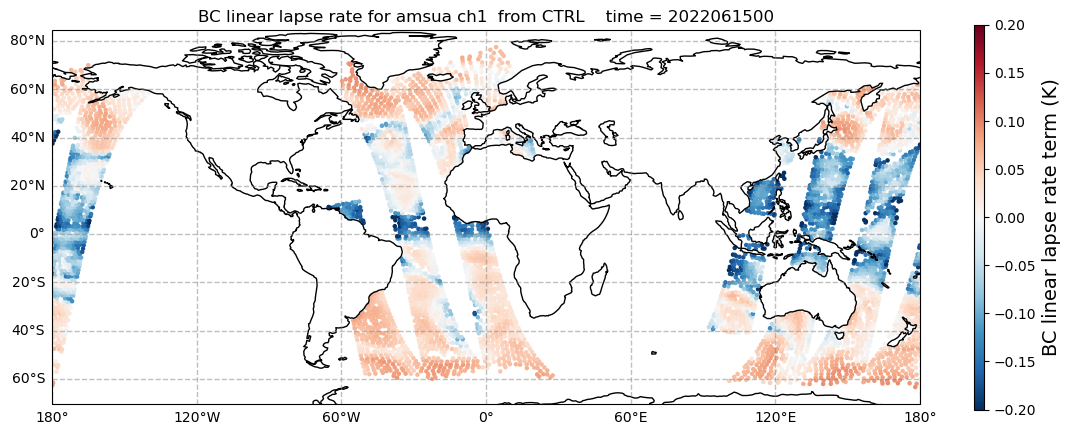

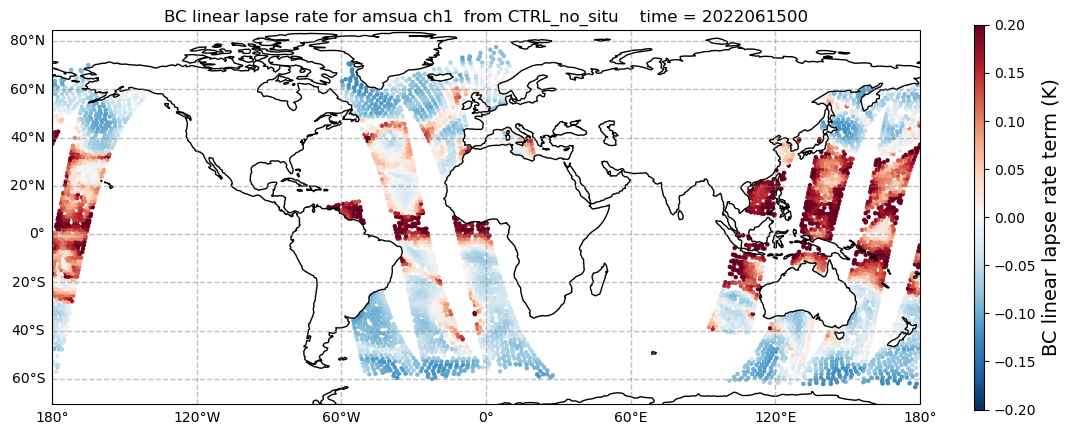

In [487]:
# check the bias correction term (not constant, but predictor*constant) for linear lapse rate 

for i, exp in enumerate(expname):
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot(projection=ccrs.PlateCarree())

    ax.coastlines()
    scatter1 = ax.scatter(lon_use[i], lat_use[i], c=bc_lapse_use[i], s=5, vmin=-0.2, vmax=0.2, cmap='RdBu_r')
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Hide labels on the top side
    gl.right_labels = False  # Hide labels on the right side
    ax.set_title(f'BC linear lapse rate for {instr} ch{chn}  from {exp}    time = {inq_time}')
    cbar = fig.colorbar(scatter1,location='right',aspect=40)
    cbar.set_label('BC linear lapse rate term (K)', fontsize=14)

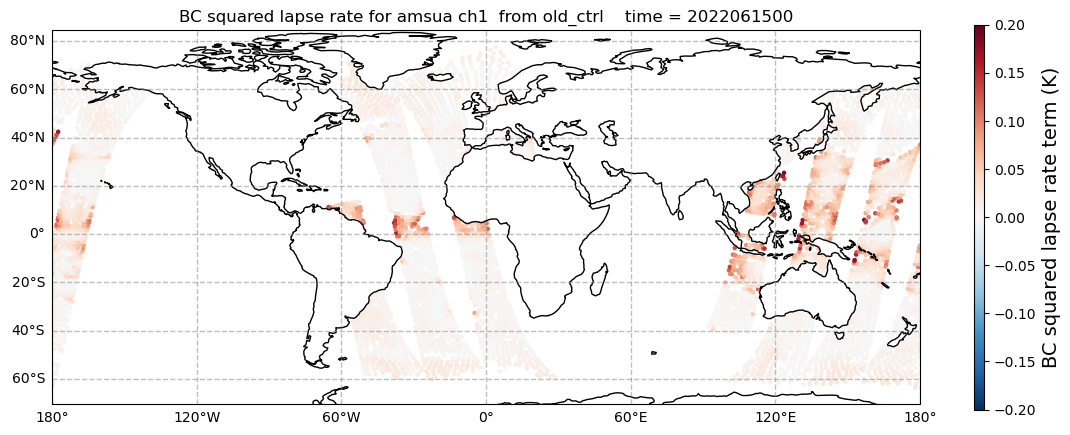

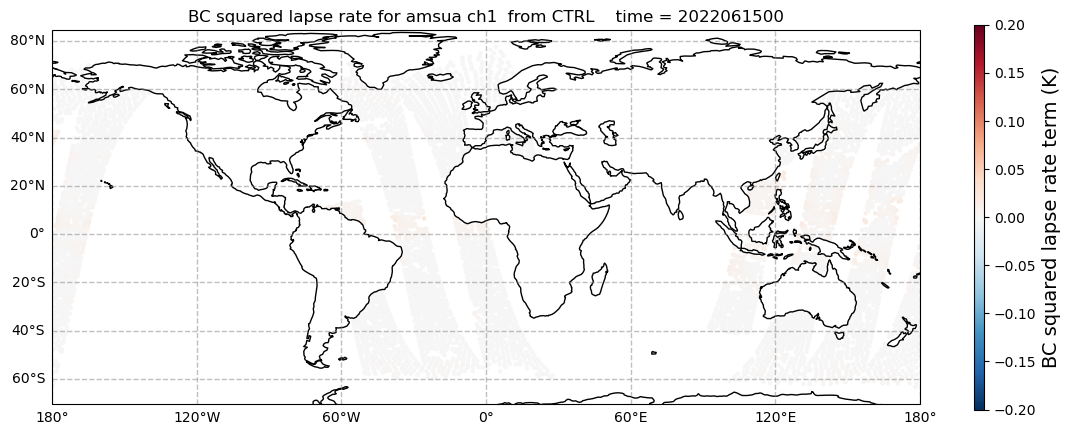

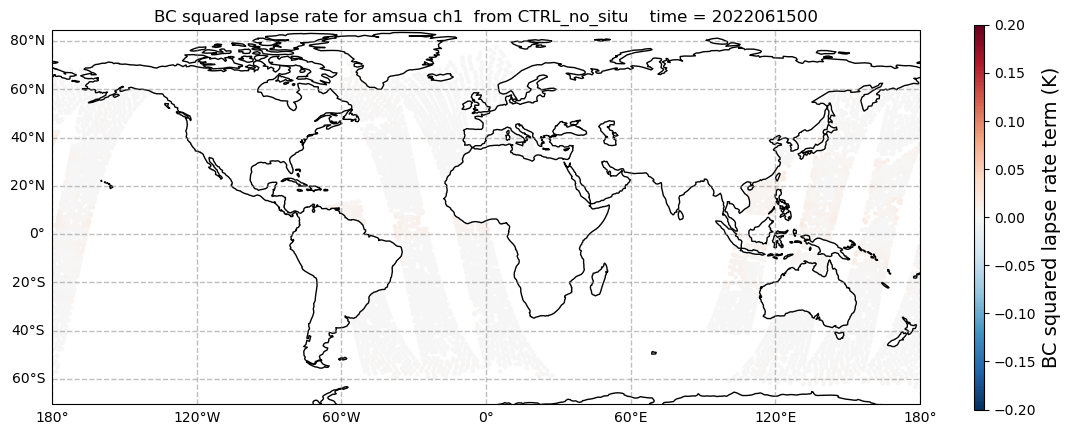

In [488]:
# check the bias correction term (not constant, but predictor*constant) for sqaured lapse rate 

for i, exp in enumerate(expname):
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot(projection=ccrs.PlateCarree())

    ax.coastlines()
    scatter1 = ax.scatter(lon_use[i], lat_use[i], c=bc_lapse_sq_use[i], s=5, vmin=-0.20, vmax=0.20, cmap='RdBu_r')
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Hide labels on the top side
    gl.right_labels = False  # Hide labels on the right side
    ax.set_title(f'BC squared lapse rate for {instr} ch{chn}  from {exp}    time = {inq_time}')
    cbar = fig.colorbar(scatter1,location='right',aspect=40)
    cbar.set_label('BC squared lapse rate term (K)', fontsize=14)

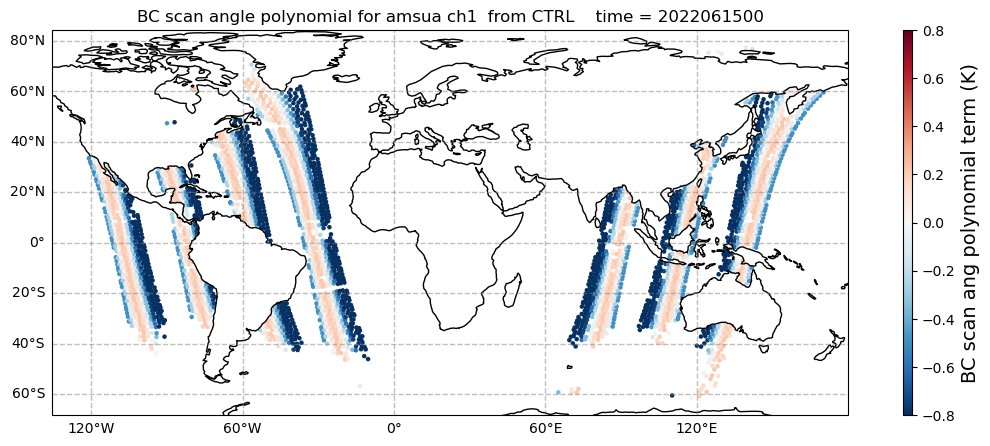

In [9]:
# check the scan-angle term

for i, exp in enumerate(expname):
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot(projection=ccrs.PlateCarree())

    ax.coastlines()
    scatter1 = ax.scatter(lon_use[i], lat_use[i], c=np.sum(bc_angord_use[i],axis=0), s=5, vmin=-0.8, vmax=0.8, cmap='RdBu_r')
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Hide labels on the top side
    gl.right_labels = False  # Hide labels on the right side
    ax.set_title(f'BC scan angle polynomial for {instr} ch{chn}  from {exp}    time = {inq_time}')
    cbar = fig.colorbar(scatter1,location='right',aspect=40)
    cbar.set_label('BC scan ang polynomial term (K)', fontsize=14)

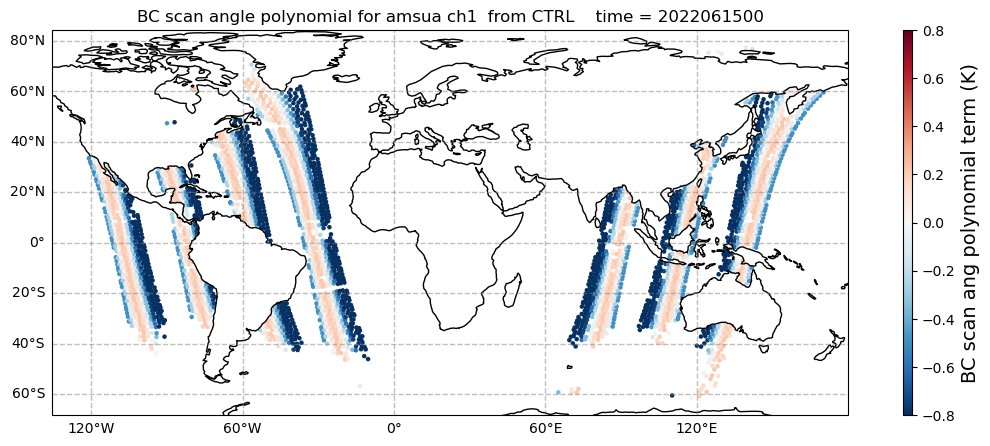

In [10]:
# check the fixed scan-angle term (external scan angle?!)

for i, exp in enumerate(expname):
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot(projection=ccrs.PlateCarree())

    ax.coastlines()
    scatter1 = ax.scatter(lon_use[i], lat_use[i], c=bc_fixed_scan_use[i], s=5, vmin=-0.8, vmax=0.8, cmap='RdBu_r')
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Hide labels on the top side
    gl.right_labels = False  # Hide labels on the right side
    ax.set_title(f'BC scan angle polynomial for {instr} ch{chn}  from {exp}    time = {inq_time}')
    cbar = fig.colorbar(scatter1,location='right',aspect=40)
    cbar.set_label('BC scan ang polynomial term (K)', fontsize=14)

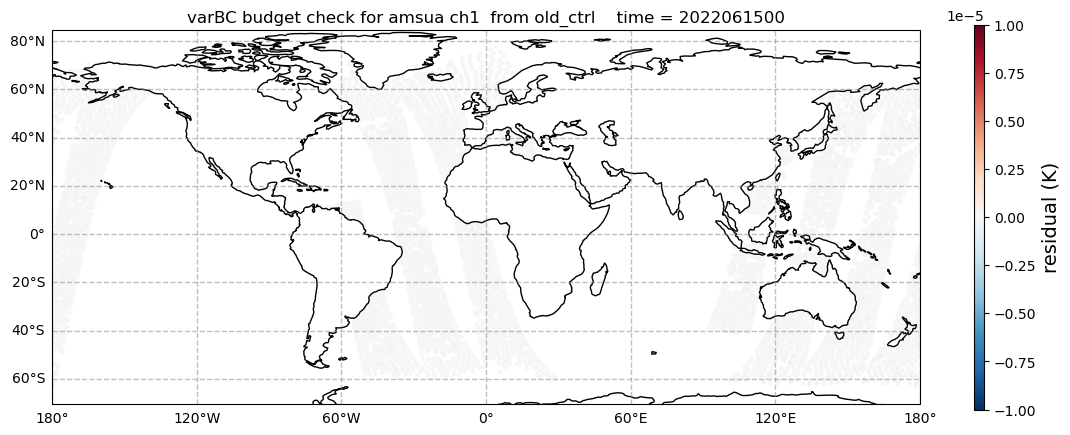

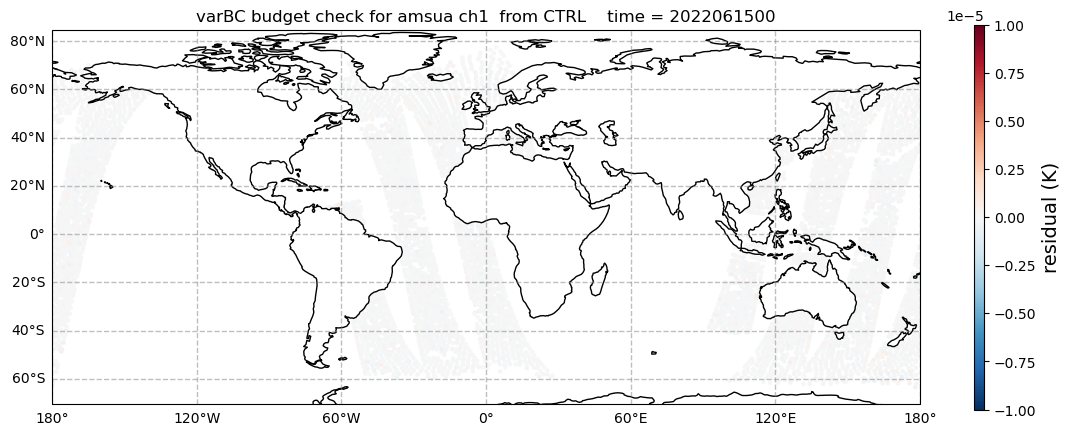

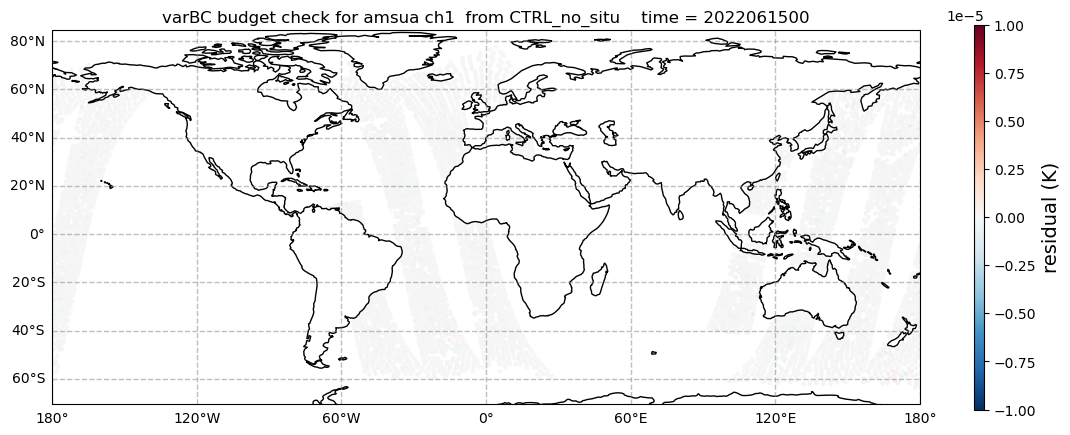

In [490]:
# residual (other terms):
lhs={}; rhs={};

for i, exp in enumerate(expname):
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot(projection=ccrs.PlateCarree())
    
    lhs[i] = omfnbc_use[i]-omf_use[i]
    rhs[i] = bc_cnst_use[i] + np.sum(bc_angord_use[i],axis=0) + bc_lapse_use[i]+bc_lapse_sq_use[i]

    ax.coastlines()
    scatter1 = ax.scatter(lon_use[i], lat_use[i], c=lhs[i]-rhs[i], s=5, vmin=-0.00001, vmax=0.00001, cmap='RdBu_r')
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Hide labels on the top side
    gl.right_labels = False  # Hide labels on the right side
    ax.set_title(f'varBC budget check for {instr} ch{chn}  from {exp}    time = {inq_time}')
    cbar = fig.colorbar(scatter1,location='right',aspect=40)
    cbar.set_label('residual (K)', fontsize=14)

In [398]:
# check the constant
print(np.mean(bc_cnst_use))
print(np.min(bc_cnst_use))
print(np.max(bc_cnst_use))

1.6979492
1.697949
1.697949


In [336]:
print(np.mean(omfnbc_use-omf_use))
print(np.max(omfnbc_use-omf_use))
print(np.min(omfnbc_use-omf_use))

1.4847932
2.2682266
0.5274792


In [337]:
print(np.mean(bc_lapse_use))
print(np.min(bc_lapse_use))
print(np.max(bc_lapse_use))

0.002068311
-0.025621139
0.0726523


In [338]:
print(np.mean(bc_lapse_sq_use))
print(np.min(bc_lapse_sq_use))
print(np.max(bc_lapse_sq_use))

0.014457603
1.8316574e-09
0.22889493


In [53]:
print(np.mean(bc_clw_use))
print(np.min(bc_clw_use))
print(np.max(bc_clw_use))

0.0
0.0
0.0


In [92]:
print(np.mean(bc_emis_use))
print(np.min(bc_emis_use))
print(np.max(bc_emis_use))

0.0
-0.0
-0.0


In [51]:
bc_angord.shape
#bc_cnst.shape

(138810, 4)

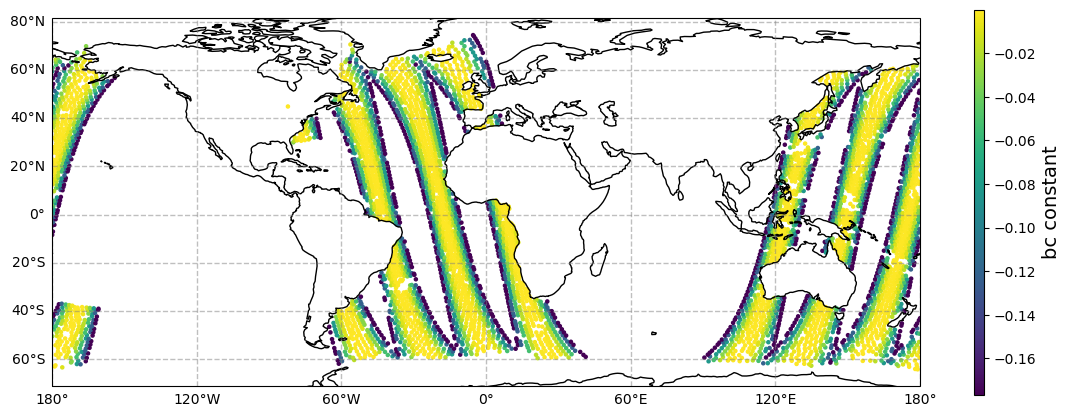

In [386]:
# check the scan-angle(?) term (need to figure out what does 'angord' mean exactly...)

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(projection=ccrs.PlateCarree())

ax.coastlines()
scatter1 = ax.scatter(lon_use, lat_use, c=bc_angord_use[0,:], s=5)

gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Hide labels on the top side
gl.right_labels = False  # Hide labels on the right side
cbar = fig.colorbar(scatter1,location='right',aspect=40)
cbar.set_label('bc constant', fontsize=14)

In [362]:
bc_angord_use.shape

(1, 5010, 4)